<a href="https://colab.research.google.com/github/rajatkb/Udacity_Pytorch_challenge_Lab_Project/blob/master/Udacity_Pytorch_scholarship_final_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install Pillow==4.1.0
!pip install PIL
!pip install image

  Using cached https://files.pythonhosted.org/packages/e7/14/ce7a5cc750ae3a8506d57997d4f18a0674fe45dd843882b9580f06b6d8f1/Pillow-4.1.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.1.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
!wget 'https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip'
!unzip 'flower_data.zip'

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

In [0]:
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

data_dir = 'flower_data'
batch_size = 4

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
dataset_sizes['test'] = int(dataset_sizes['valid']*0.1)
dataset_sizes['valid'] = dataset_sizes['valid'] - dataset_sizes['test']
image_datasets['valid'] , image_datasets['test'] = torch.utils.data.random_split(image_datasets['valid'] ,[dataset_sizes['valid'],dataset_sizes['test']])
image_datasets['valid'] , image_datasets['test'] = image_datasets['valid'].dataset , image_datasets['test'].dataset
## We work towards splitting our data by taking a small portion of validation set. Hence keeping our model selection or training free of our biases about validation

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True , num_workers = 2) for x in ['train', 'valid' , 'test']}


print(dataset_sizes , dataloaders , image_datasets)

{'train': 6552, 'valid': 737, 'test': 81} {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f454f54e2e8>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7f454f549be0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f454f549da0>} {'train': Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flower_data/train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomRotation(degrees=(-45, 45), resample=False, expand=False)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None, 'valid': Dataset ImageFolder
    Number of datapoints: 818
    Root Location: flower_data/valid
    Transforms

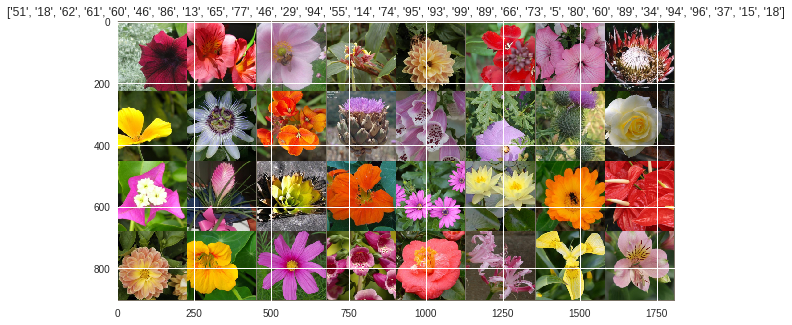

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (10 , 50))
    if title is not None:
        plt.title(title)
    plt.imshow(inp)
    plt.show()

class_names = image_datasets['test'].classes
inputs, classes = next(iter(dataloaders['test'])) ## Let us see one sample
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

(array([11., 10., 10., 10., 10., 10., 10., 10., 10., 11.]),
 array([  1. ,  11.1,  21.2,  31.3,  41.4,  51.5,  61.6,  71.7,  81.8,
         91.9, 102. ]),
 <a list of 10 Patch objects>)

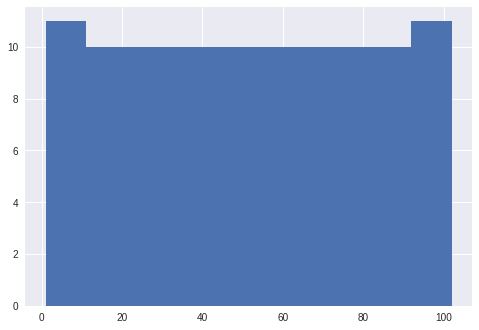

In [0]:
classes = [int(x) for x in image_datasets['valid'].classes]
plt.hist(classes) ## Yes the distribution is a bit of in few classes may affect prediction but augmentation should take care of any sort of tendency of creating bias

In [0]:
### We start building the model here ####

resnet152 = models.resnet18(pretrained = True)
# for param in resnet152.parameters():
#     param.requires_grad = False
feature_size = resnet152.fc.in_features
# resnet152

In [0]:
class Net(nn.Module):
  def __init__(self , inp = 2048 , out = 102):
    super(Net , self).__init__()
    self.linear1 = nn.Linear(inp , out)
#     self.dropout = nn.Dropout(0.2)
#     self.linear2 = nn.Linear(1024 , 512)
#     self.linear3 = nn.Linear(512 , 256 )
#     self.linear4 = nn.Linear(256 , out)
  def forward(self , x):
    x = self.linear1(x)
#     x = self.dropout(self.linear2(x))
#     x = self.dropout(self.linear3(x))
#     x = self.linear4(x)
    return x

In [0]:
fc_net = Net(feature_size , 102)

In [0]:
fc_net

Net(
  (linear1): Linear(in_features=512, out_features=102, bias=True)
)

In [0]:
resnet152.fc = fc_net

In [0]:
if train_on_gpu:
    resnet152 = resnet152.to(torch.device("cuda"))
    
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(resnet152.parameters(), lr=0.0001, momentum=0.9)
resnet152

In [0]:
import time
import copy

def train_model(model , criterion , optimizer , scheduler=None , num_epochs = 25):
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train' , 'valid']:
            if phase == 'train':
              print("train phase!")
              model = model.train()
            elif phase == 'valid':
              print("validation phase!")
              model = model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for data in dataloaders[phase]:
                inputs , labels = data

                if train_on_gpu:
                  inputs = inputs.cuda()
                  labels = labels.cuda()

                optimizer.zero_grad()

                outputs = model(inputs)

                _,preds = torch.max(outputs.data , 1)
                loss = criterion(outputs , labels)

                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
#                 print(running_corrects)
            d = dataset_sizes[phase]
            epoch_loss = float(running_loss) / float(d) 
            epoch_acc = float(running_corrects) / float(d) 
            
            print('{} Loss: {} Acc: {}'.format(
                  phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':best_model_wts,'optim':optimizer.state_dict()}
                torch.save(state,'model_weights.pth')

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
#     model = model.cpu()
    model.load_state_dict(best_model_wts)
#     model = model.gpu()
    
    return model
    


In [0]:
class_names = image_datasets['train'].classes
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        #print(labels)
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            img = np.clip(inputs.cpu().data[j].numpy().transpose(1,2,0) * std + mean, 0, 1)
            plt.imshow(img)
            
            if images_so_far == num_images:
                return

In [0]:
model_final = train_model(resnet152 , criterion , optimizer_ft , num_epochs = 1)

Epoch 0/0
----------
train phase!
train Loss: 0.12996761590897382 Acc: 0.8835470085470085
validation phase!
valid Loss: 0.03910417359428457 Acc: 1.0637720488466758

Training complete in 1m 35s
Best val Acc: 1.063772


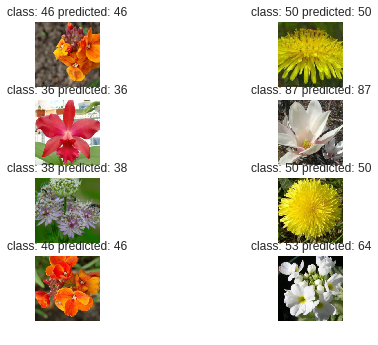

In [0]:
visualize_model(model_final)

In [0]:
def save_cpu(model , optimizer , path = ''):
    model = model.to(torch.device("cpu"))
    best_model_wts = model.state_dict()
    # saving a checkpoint to use for next time to save time used in training from scratch
    state = {'model':best_model_wts,'optim':optimizer.state_dict()}
    torch.save(state,path+'/cpu_model_weights.pth')


In [0]:
save_cpu(model_final , optimizer_ft )

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
save_cpu(model_final , optimizer_ft , path = '/content/gdrive/My Drive')